In [1]:
#%load_ext autoreload
#%autoreload 2
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

In [2]:
from torch.nn import Parameter

def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                          missing_keys, unexpected_keys, error_msgs):
    r"""Copies parameters and buffers from :attr:`state_dict` into only
    this module, but not its descendants. This is called on every submodule
    in :meth:`~torch.nn.Module.load_state_dict`. Metadata saved for this
    module in input :attr:`state_dict` is provided as :attr:`local_metadata`.
    For state dicts without metadata, :attr:`local_metadata` is empty.
    Subclasses can achieve class-specific backward compatible loading using
    the version number at `local_metadata.get("version", None)`.

    .. note::
        :attr:`state_dict` is not the same object as the input
        :attr:`state_dict` to :meth:`~torch.nn.Module.load_state_dict`. So
        it can be modified.

    Arguments:
        state_dict (dict): a dict containing parameters and
            persistent buffers.
        prefix (str): the prefix for parameters and buffers used in this
            module
        local_metadata (dict): a dict containing the metadata for this module.
            See
        strict (bool): whether to strictly enforce that the keys in
            :attr:`state_dict` with :attr:`prefix` match the names of
            parameters and buffers in this module
        missing_keys (list of str): if ``strict=True``, add missing keys to
            this list
        unexpected_keys (list of str): if ``strict=True``, add unexpected
            keys to this list
        error_msgs (list of str): error messages should be added to this
            list, and will be reported together in
            :meth:`~torch.nn.Module.load_state_dict`
    """
    for hook in self._load_state_dict_pre_hooks.values():
        hook(state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs)

    local_name_params = itertools.chain(self._parameters.items(),
                                        self._buffers.items())
    local_state = {k: v.data for k, v in local_name_params if v is not None}

    for name, param in local_state.items():
        key = prefix + name
        if key in state_dict:
            input_param = state_dict[key]

            # Backward compatibility: loading 1-dim tensor from 0.3.* to version 0.4+
            if len(param.shape) == 0 and len(input_param.shape) == 1:
                input_param = input_param[0]

            if input_param.shape != param.shape:
                # local shape should match the one in checkpoint
                error_msgs.append(
                    'size mismatch for {}: copying a param with shape {} from checkpoint, '
                    'the shape in current model is {}.'.format(
                        key, input_param.shape, param.shape))
                #if not strict:
                #    continue

            if isinstance(input_param, Parameter):
                # backwards compatibility for serialized parameters
                input_param = input_param.data

            try:
                param.copy_(input_param)
            except Exception:
                error_msgs.append(
                    'While copying the parameter named "{}", '
                    'whose dimensions in the model are {} and '
                    'whose dimensions in the checkpoint are {}.'.format(
                        key, param.size(), input_param.size()))
                # PG load partially

                if len(input_param.size()) == 3:
                    error_msgs.append(
                        'Partially copying the parameter named "{}", '
                        'whose dimensions in the model are {} and '
                        'whose dimensions in the checkpoint are {}. - trying {}'
                        .format(
                            key, param.size(), input_param.size(),
                            param[:input_param.size()[0], :input_param.size(
                            )[1], :input_param.size()[2]].shape))
                else:
                    error_msgs.append(
                        'Partially copying the parameter named "{}", '
                        'whose dimensions in the model are {} and '
                        'whose dimensions in the checkpoint are {}. - trying {}'
                        .format(key, param.size(), input_param.size(),
                                param[:input_param.size()[0]].shape))

                try:
                    new_input_param = torch.empty_like(param)
                    new_input_param = torch.nn.init.normal_(new_input_param,
                                                            mean=input_param.mean(),
                                                            std=input_param.std())

                    if len(input_param.size()) == 3:
                        new_input_param[:input_param.size()[0], :input_param.
                                        size()[1], :input_param.size(
                                        )[2]] = input_param
                    else:
                        new_input_param[:input_param.size()[0]] = input_param
                    param.copy_(new_input_param)
                except Exception as e:
                    assert e
                    error_msgs.append(
                        'Failed to load weights partially {}'.format(e))
        elif strict:
            missing_keys.append(key)

    if strict:
        for key in state_dict.keys():
            if key.startswith(prefix):
                input_name = key[len(prefix):]
                input_name = input_name.split(
                    '.', 1)[0]  # get the name of param/buffer/child
                if input_name not in self._modules and input_name not in local_state:
                    unexpected_keys.append(key)

def load_state_dict(self, state_dict, strict=True):
    r"""Copies parameters and buffers from :attr:`state_dict` into
    this module and its descendants. If :attr:`strict` is ``True``, then
    the keys of :attr:`state_dict` must exactly match the keys returned
    by this module's :meth:`~torch.nn.Module.state_dict` function.

    Arguments:
        state_dict (dict): a dict containing parameters and
            persistent buffers.
        strict (bool, optional): whether to strictly enforce that the keys
            in :attr:`state_dict` match the keys returned by this module's
            :meth:`~torch.nn.Module.state_dict` function. Default: ``True``

    Returns:
        ``NamedTuple`` with ``missing_keys`` and ``unexpected_keys`` fields:
            * **missing_keys** is a list of str containing the missing keys
            * **unexpected_keys** is a list of str containing the unexpected keys
    """
    missing_keys = []
    unexpected_keys = []
    error_msgs = []

    # copy state_dict so _load_from_state_dict can modify it
    metadata = getattr(state_dict, '_metadata', None)
    state_dict = state_dict.copy()
    if metadata is not None:
        state_dict._metadata = metadata

    def load(module, prefix=''):
        local_metadata = {} if metadata is None else metadata.get(
            prefix[:-1], {})
        module._load_from_state_dict(state_dict, prefix, local_metadata, True,
                                     missing_keys, unexpected_keys, error_msgs)
        for name, child in module._modules.items():
            if child is not None:
                load(child, prefix + name + '.')
                
    load(self)

    if strict:
        if len(unexpected_keys) > 0:
            error_msgs.insert(
                0, 'Unexpected key(s) in state_dict: {}. '.format(', '.join(
                    '"{}"'.format(k) for k in unexpected_keys)))
        if len(missing_keys) > 0:
            error_msgs.insert(
                0, 'Missing key(s) in state_dict: {}. '.format(', '.join(
                    '"{}"'.format(k) for k in missing_keys)))

    if strict and len(error_msgs) > 0:
        raise RuntimeError(
            'Error(s) in loading state_dict for {}:\n\t{}'.format(
                self.__class__.__name__, "\n\t".join(error_msgs)))
    return None

In [3]:
nn.Module._load_from_state_dict = _load_from_state_dict
nn.Module.load_state_dict = load_state_dict

In [4]:
from fastai import *
from fastai.basic_train import *
from fastai.basic_data import *
from fastai.data_block import *
from fastai.torch_core import *
from fastai.train import *
from fastai.callback import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.layers import *

In [5]:
# deterministic
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
fname_ext = lambda fname,ext: f'{str(fname)[:-4]}{ext}{str(fname)[-4:]}'

def preprocess(fname, type_index=None, ext=''):
    t  = pd.read_csv(fname_ext(fname,ext))
    s  = pd.read_csv('structures.csv')
    
    has_y = 'scalar_coupling_constant' in t.columns

    if has_y:
        # atom-atom level
        # molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
        scalar_couplings = pd.read_csv(f'scalar_coupling_contributions{ext}.csv') # fc,sd,pso,dso

        # atom level
        # molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
        magnetic_shielding = pd.read_csv('magnetic_shielding_tensors.csv')
        # molecule_name,atom_index,mulliken_charge
        mulliken_charges = pd.read_csv('mulliken_charges.csv')

        # molecule level
        # molecule_name,X,Y,Z
        dipole_moments = pd.read_csv('dipole_moments.csv')
        # molecule_name,potential_energy
        potential_energy = pd.read_csv('potential_energy.csv')

    t['molecule_index'] = pd.factorize(t['molecule_name'])[0] + t['id'].min()
    # make sure we use the same indexes in train/test (test needs to provide type_index)
    if type_index is not None:
        t['type_idx'] = t['type'].apply(lambda x: type_index.index(x) ) # pd.factorize(pd.concat([pd.Series(type_index),t['type']]))[0][len(type_index):]
    else:
        t['type_idx'] = pd.factorize(t['type'])[0]

    s['atom_idx'] = s['atom'].apply(lambda x: atoms.index(x) )

    max_items = len(t.groupby(['molecule_name', 'atom_index_0']))# if has_y else 422550
    max_atoms = int(s.atom_index.max() + 1)

    if has_y:
        contributions = ['fc','sd','pso','dso']
        magnetic_tensors = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
        XYZ = ['X','Y','Z']
    xyz = ['x', 'y', 'z']
    
    x_xyz   = np.zeros((max_items,len(xyz),  max_atoms), dtype=np.float32)
    x_type  = np.zeros((max_items,1,         max_atoms), dtype=np.int8)
    x_ext   = np.zeros((max_items,1,         max_atoms), dtype=np.bool_)
    x_atom  = np.empty((max_items,1,         max_atoms), dtype=np.int8)
    x_atom[:] = -1

    if has_y:
        y_scalar   = np.zeros((max_items,len(contributions)   ,max_atoms), dtype=np.float32)
        y_magnetic = np.zeros((max_items,len(magnetic_tensors),max_atoms), dtype=np.float32)
        y_mulliken = np.zeros((max_items,1                    ,max_atoms), dtype=np.float32)

        y_dipole   = np.zeros((max_items,len(XYZ)), dtype=np.float32)
        y_potential= np.zeros((max_items,1       ), dtype=np.float32)

        y_magnetic[...] = np.nan
        y_mulliken[...] = np.nan
    else:
        xt_ids = np.zeros((max_items, max_atoms), dtype=np.int32)

    m = np.zeros((max_items,), dtype=np.int32)
    i = j = 0
    
    for (m_name, m_index) ,m_group in tqdm(t.groupby(['molecule_name', 'molecule_index'])):
        ss = s[s.molecule_name==m_name]
        n_atoms = len(ss)
        if has_y:
            magnetic = magnetic_shielding[
                    (magnetic_shielding['molecule_name']==m_name)][magnetic_tensors].values.T

            mulliken = mulliken_charges[
                    (mulliken_charges['molecule_name']==m_name)]['mulliken_charge'].values.T

            scs = scalar_couplings[scalar_couplings['molecule_name']==m_name]
            
            y_dipole[j,:]= dipole_moments[dipole_moments['molecule_name']==m_name][XYZ].values
            y_potential[j,:]=potential_energy[
                potential_energy['molecule_name']==m_name]['potential_energy'].values
        
        for a_name,a_group in m_group.groupby('atom_index_0'):
            
            ref_a = ss[ss['atom_index']==a_name]
            
            x_xyz[i] = 0.
            x_type[i] = -1
            x_ext[i] =  True
            
            x_xyz[i,:,:n_atoms] = (ss[xyz].values-ref_a[xyz].values).T  # xyz 
            x_type[i,0,a_group['atom_index_1']] = a_group['type_idx']  # type 
            x_ext[i,0,a_group['atom_index_1']] = a_group['ext']  # ext 
            x_atom[i,:,:n_atoms] = ss['atom_idx'].T                

            if has_y:
                y_scalar[i,:,a_group['atom_index_1']] = scs[scs['atom_index_0']==a_name][contributions]
                y_magnetic[i,:,:n_atoms] = magnetic
                y_mulliken[i,:,:n_atoms] = mulliken
            else:
                xt_ids[i,a_group['atom_index_1']] = a_group['id']  

            m[i] = m_index
            i+=1
        j += 1
    assert i == max_items
    print(i,max_items)
    if has_y:
        return x_xyz,x_type,x_ext,x_atom, m, y_scalar, y_magnetic, y_mulliken, y_dipole, y_potential
    else:
        return x_xyz,x_type,x_ext,x_atom, m, xt_ids

Define where you want to use original training set '' or extended ''

In [7]:
ext = '_ext' # or ''

Load preprocessed or preprocess and save for later

In [8]:
train_fname = Path('train.npz')
types = ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'] 
atoms = 'CFHNO'

try:
    npzfile = np.load(fname_ext(train_fname, ext))
    x_xyz   = npzfile['x_xyz']
    x_type  = npzfile['x_type']
    x_ext   = npzfile['x_ext']
    x_atom  = npzfile['x_atom']

    y_scalar    = npzfile['y_scalar']
    y_magnetic  = npzfile['y_magnetic']
    y_mulliken  = npzfile['y_mulliken']
    y_dipole    = npzfile['y_dipole']
    y_potential = npzfile['y_potential']
    m = npzfile['m']
    max_items, max_atoms = x_xyz.shape[0], x_xyz.shape[-1]
except:
    x_xyz,x_type,x_ext,x_atom, m, y_scalar, y_magnetic, y_mulliken, y_dipole, y_potential = \
        preprocess(train_fname.with_suffix('.csv'), type_index=types, ext=ext)
    np.savez(fname_ext(train_fname, ext), 
             x_xyz=x_xyz,
             x_type=x_type,
             x_ext=x_ext,
             x_atom=x_atom,
             y_scalar=y_scalar,
             y_magnetic=y_magnetic,
             y_mulliken=y_mulliken,
             y_dipole=y_dipole,
             y_potential=y_potential,
             m=m)
n_types = int(x_type[~np.isnan(x_type)].max() + 1)

In [9]:
use_memmap = True
load_fn = np.load if not use_memmap else partial(np.lib.format.open_memmap, mode='r')

In [10]:
x_qm9_mulliken = load_fn(f'x_qm9_mulliken{ext}.npy')

In [11]:
[v.shape for v in [x_xyz,x_type,x_ext,x_atom,x_qm9_mulliken, 
                   y_scalar, y_magnetic, y_mulliken, y_dipole, y_potential, m]]

[(1405126, 3, 29),
 (1405126, 1, 29),
 (1405126, 1, 29),
 (1405126, 1, 29),
 (1405126, 1, 29),
 (1405126, 4, 29),
 (1405126, 9, 29),
 (1405126, 1, 29),
 (1405126, 3),
 (1405126, 1),
 (1405126,)]

In [12]:
real_atom_mask = (x_atom != -1).swapaxes(1,2).squeeze(-1)
real_atom_mask.shape

(1405126, 29)

In [13]:
x_xyz_masked = x_xyz.swapaxes(1,2)[real_atom_mask]

In [14]:
x_xyz_masked.shape

(26154396, 3)

In [15]:
# BAD mean/std
#x_xyz_mean, x_xyz_std = Tensor(x_xyz.mean(axis=(0,2),keepdims=True)), Tensor(x_xyz.std(axis=(0,2),keepdims=True))
#x_xyz_mean = Tensor(x_xyz).mean(dim=(0,2),keepdim=True)
#x_xyz_std  = Tensor(x_xyz).std(dim=(0,2), keepdim=True)

In [16]:
# GOOD mean/std
x_xyz_mean = Tensor(x_xyz_masked).mean(dim=(0),keepdim=True).unsqueeze(-1)
x_xyz_std  = Tensor(x_xyz_masked).std(dim=(0), keepdim=True).unsqueeze(-1)

In [17]:
x_xyz_mean, x_xyz_std, x_xyz_std.shape

(tensor([[[ 0.0094],
          [-0.0328],
          [ 0.0032]]]), tensor([[[1.8703],
          [2.2832],
          [1.7753]]]), torch.Size([1, 3, 1]))

In [18]:
#x_xyz = (x_xyz - x_xyz_mean.numpy() ) / x_xyz_std.numpy()

In [19]:
x_qm9_mulliken_mean = Tensor(x_qm9_mulliken.mean(axis=(0,2),keepdims=True))
x_qm9_mulliken_std  = Tensor(x_qm9_mulliken.std( axis=(0,2),keepdims=True))

In [20]:
x_xyz_std.shape

torch.Size([1, 3, 1])

Fastai classes (this should should be done into its own `application` but who has time?

In [21]:
class MoleculeItem(ItemBase):
    def __init__(self,i,xyz,type,ext,atom,qm9_mulliken): 
        self.i,self.xyz,self.type,self.ext, self.atom,self.qm9_mulliken = \
            i,xyz,type,ext,atom,qm9_mulliken
        self.data = [Tensor(xyz), LongTensor((type)), 
                     Tensor(ext), LongTensor((atom)),Tensor(qm9_mulliken)]
    def __str__(self):
        # TODO: count n_atoms correctly. 
        n_atoms = np.count_nonzero(np.sum(np.absolute(self.xyz), axis=0))+1
        n_couplings = np.sum((self.type!=-1))
        return f'{self.i} {n_atoms} atoms {n_couplings} couplings'
    
    def apply_tfms(self, tfms:Collection, **kwargs):
        x = self.clone()
        for t in tfms:
            if t: x.data = t(x.data)
        return x
    
    def clone(self):
        return self.__class__(self.i,self.xyz,self.type,self.ext,self.atom,self.qm9_mulliken)
    
class ScalarCouplingItem(ItemBase):
    def __init__(self,scalar,magnetic,mulliken,dipole,potential,**kwargs): 
        self.scalar,self.magnetic,self.mulliken,self.dipole,self.potential = \
            scalar,magnetic,mulliken,dipole,potential
        self.data = (Tensor(scalar), Tensor(magnetic), Tensor(dipole), Tensor(potential))
    def __str__(self):
        res, spacer, n_couplings = '', '', 0
        for s in self.data[0].sum(dim=0):
            if s==0.: spacer = ' * '
            else: 
                res += f'{spacer}{s:.4f}'
                spacer = ' '
                n_couplings +=1
        return f'{n_couplings}: {res}'
    def apply_tfms(self, tfms:Collection, **kwargs):
        y = self.clone()
        for t in tfms:
            if 'label_smoothing' == t.__name__:
                if t: y.data = t(y.data)
        return y
    def clone(self):
        return self.__class__(self.scalar,self.magnetic,self.mulliken,self.dipole,self.potential)
    def __hash__(self): return hash(str(self))

In [22]:
y_scalar.mean(axis=(0,2))

array([ 3.588289,  0.018822,  0.085776, -0.053406], dtype=float32)

In [23]:
class LMAEMaskedLoss(Module):
    def __init__(self, contrib_w=0., magnetic_w=0., dipole_w=0., potential_w=0., 
                 types_w = [1]*n_types, return_all=False, proxy_log=torch.log, exclude_ext=False):
        self.contrib_w,self.magnetic_w,self.dipole_w,self.potential_w = contrib_w,magnetic_w,dipole_w,potential_w
        self.types_w = types_w
        self.return_all = return_all
        self.proxy_log = proxy_log
        self.exclude_ext = exclude_ext
    
    def forward(self, input_outputs, t_scalar, t_magnetic, t_dipole, t_potential):    
        type, ext, p_scalar, p_magnetic, p_dipole, p_potential = input_outputs
        loss = 0.
        n = 0
        j_loss = [0] * n_types
        for t in range(n_types):
            mask = (type == t).squeeze(1) if not self.exclude_ext else ((type == t) & (ext == 0)).squeeze(1)
            if mask.sum() > 0:
                _output,_target = p_scalar.transpose(1,2)[mask], t_scalar.transpose(1,2)[mask] # scalars at the end
                # LMAE scalar
                s_loss = self.proxy_log((_output.sum(dim=-1) - _target.sum(dim=-1)).abs().mean()+1e-9)
                loss += self.types_w[t] * s_loss
                j_loss[t] += s_loss
                # LMAE scalar contributions
                for i_contrib in range(_output.shape[-1]):
                    loss += self.contrib_w * ((_output[...,i_contrib] - _target[...,i_contrib])**2).mean()
                n+=1
        loss /= n
        
        if self.magnetic_w > 0:
            mask = ~torch.isnan(t_magnetic)
            loss += self.magnetic_w * MSELossFlat()(p_magnetic[mask], t_magnetic[mask])
            
        if self.dipole_w    > 0: loss += self.dipole_w    * MSELossFlat()(p_dipole,    t_dipole)
        if self.potential_w > 0: loss += self.potential_w * MSELossFlat()(p_potential, t_potential)

        return loss if not self.return_all else (loss, *j_loss)

In [24]:
class ScalarCouplingList(ItemList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        self.loss_func = LMAEMaskedLoss

    def get(self, i):
        o = super().get(i)
        return ScalarCouplingItem(*o)

    def reconstruct(self,t): return 0; # TODO for viz !!!! ScalarCouplingItem(t.numpy())

Quaterions allow us to rotate 3d points randoming with a nice uniform distribution of 3 numbers hece we use them, however it's still to be seen if are useful here

In [25]:
#https://github.com/facebookresearch/QuaterNet/blob/master/common/quaternion.py
def qrot(q, v):
    """
    Rotate vector(s) v about the rotation described by quaternion(s) q.
    Expects a tensor of shape (*, 4) for q and a tensor of shape (*, 3) for v,
    where * denotes any number of dimensions.
    Returns a tensor of shape (*, 3).
    """
    assert q.shape[-1] == 4
    assert v.shape[-1] == 3
    assert q.shape[:-1] == v.shape[:-1]
    
    original_shape = list(v.shape)
    q = q.view(-1, 4)
    v = v.view(-1, 3)
    
    qvec = q[:, 1:]
    uv = torch.cross(qvec, v, dim=1)
    uuv = torch.cross(qvec, uv, dim=1)
    return (v + 2 * (q[:, :1] * uv + uuv)).view(original_shape)

def random_rotation(data):
    x_xyz = data[0].transpose(0,1)
    r = torch.rand(3)
    sq1_v1,sqv1,v2_2pi,v3_2pi = torch.sqrt(1-r[:1]),torch.sqrt(r[:1]),2*math.pi*r[1:2],2*math.pi*r[2:3]
    q = torch.cat([sq1_v1*torch.sin(v2_2pi), sq1_v1*torch.cos(v2_2pi), 
                   sqv1  *torch.sin(v3_2pi), sqv1  *torch.cos(v3_2pi)], dim=0).unsqueeze(0)
    x_xyz = qrot(q.expand(x_xyz.shape[0],-1), x_xyz).squeeze(0).transpose(0,1)
    return (x_xyz, *data[1:])

def normalize(data):
    sq = False
    if data[0].ndim < 3:
        data[0].unsqueeze_(0)
        data[4].unsqueeze_(0)
        sq = True
    x_xyz      = (data[0] - x_xyz_mean)          / x_xyz_std
    x_mulliken = (data[4] - x_qm9_mulliken_mean) / x_qm9_mulliken_std
    if sq:
        x_xyz.squeeze_(0)
        x_mulliken.squeeze_(0)
    return (x_xyz, data[1],data[2],data[3],x_mulliken)

def canonize(data):
    xyz,type,ext,atom,mulliken = data
    mask = (atom == -1).squeeze(0)
    i_max_atom = torch.nonzero(atom != -1).max() + 1
    #mask_atoms = torch.ones((max_atoms,   max_atoms), dtype=torch.uint8)
    #zeros      = torch.zeros((i_max_atom, i_max_atom), dtype=torch.uint8)
    #mask_atoms[:zeros.shape[0],:zeros.shape[1]] = zeros

    mask_atoms = torch.ones ((max_atoms, ), dtype=torch.uint8)
    zeros      = torch.zeros((i_max_atom,), dtype=torch.uint8)
    mask_atoms[:zeros.shape[0],] = zeros
    #mask_atoms[(type==-1).squeeze(0),:] = 1
    n_atoms = i_max_atom
    xyz[:,mask], type[:,mask],ext[:,mask],atom[:,mask],mulliken[:,mask] = 0,-1,1,-1,0
    return (xyz,type,ext,atom,mulliken, mask_atoms, n_atoms)

In [26]:
THRESHOLD=0.05
def label_smoothing(y):
    r = y[0] + torch.zeros_like(y[0]).uniform_(-THRESHOLD, THRESHOLD).masked_fill(y[0]==0, 0.)
    return (r, y[1], y[2], y[3])

Build `data` bunch etc. for fastai

In [27]:
data = ItemList(items=(MoleculeItem(i,*v) for i,v in 
                       enumerate(zip(x_xyz,x_type,x_ext,x_atom,x_qm9_mulliken))),
                label_cls=ScalarCouplingItem)

In [28]:
from sklearn.model_selection import train_test_split
_, idx_valid_split = train_test_split(range(m.max()+1), test_size=0.1, random_state=13)
idx_valid_split = np.argwhere(np.isin(m, idx_valid_split)).flatten()

In [29]:
data = data.split_by_idx(idx_valid_split)

In [30]:
data = data.label_from_func(
    func=lambda o: (y_scalar[o.i], y_magnetic[o.i], y_mulliken[o.i], y_dipole[o.i], y_potential[o.i]),
    label_cls=ScalarCouplingList)

In [31]:
tfms = [normalize, canonize]
tta_tfms = list(tfms)
#tta_tfms.insert(0,random_rotation)
data = data.transform((tta_tfms, tfms))#.transform_y(([label_smoothing], None))

In [32]:
data=data.databunch()

In [33]:
#data.train_ds.filter_by_func(lambda item, _: len(item.data[1].cpu().numpy()[item.data[1].cpu().numpy()==0]) == 0)
#data.valid_ds.filter_by_func(lambda item, _: len(item.data[1].cpu().numpy()[item.data[1].cpu().numpy()==0]) == 0)

# Model
Whole model here, self-contained (needs some cleanup)

In [34]:
class LMAEMetric(LearnerCallback):
    _order=-20 # Needs to run before the recorder
    def __init__(self, learn, val_only=True):
        super().__init__(learn)
        self.val_only=val_only
        self.metric = LMAEMaskedLoss(return_all=True, exclude_ext=True)

    def on_train_begin(self, **kwargs):
        if not self.val_only: self.learn.recorder.add_metric_names(['tLMAE'])
        self.learn.recorder.add_metric_names(['👉🏻LMAE👈🏻'] + [f'{i} {types[i]}' for i in range(n_types)])
            
    def on_batch_end(self, train, last_output, last_target, **kwargs):
        if self.val_only and train: return 
        preds,targs = self.preds[int(train)], self.targs[int(train)] # 0 val 1 train
        if preds is None:
            targs, preds = listify(last_target), listify(last_output)
            targs,preds = [t.detach() for t in targs],[t.detach() for t in preds]
        else:
            for i,(o,t) in enumerate(zip(last_output, last_target)):
                preds[i] = torch.cat([preds[i], o.detach()], dim=0)
                targs[i] = torch.cat([targs[i], t.detach()], dim=0)
        self.preds[int(train)], self.targs[int(train)] = preds,targs
        
    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = [None, None], [None, None]

    def on_epoch_end(self, last_metrics, **kwargs):
        mets = []
        if self.preds[1]: mets.append(self.metric.forward(self.preds[1], *self.targs[1])[0]) # just tLMAE
        if self.preds[0]: mets.extend(self.metric.forward(self.preds[0], *self.targs[0]))
        return add_metrics(last_metrics, mets) if mets else None

In [35]:
class DummyDecoder(Module):
    def forward(self,tgt, memory, tgt_mask=None, memory_mask=None, 
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        return memory

class AtomTorchTransformer(Module):
    def __init__(self,n_layers,n_heads,d_model,d_inner,embed_p:float=0,final_p:float=0,
                 d_head=None,deep_decoder=False,dense_out=False, **kwargs):
        
        self.d_model = d_model
        d_head = ifnone(d_head, d_model//n_heads)        
        
        self.transformer = nn.Transformer(num_encoder_layers=n_layers,
                                          nhead=n_heads,d_model=d_model,dim_feedforward=d_inner,
                                          dropout = 0., custom_decoder=DummyDecoder())
        
        channels_out = d_model*n_layers if dense_out else d_model
        channels_out_scalar = channels_out + n_types + 1
        if deep_decoder:
            sl = [int(channels_out_scalar/(2**d)) for d in range(int(math.ceil(np.log2(channels_out_scalar/4)-1)))]
            self.scalar = nn.Sequential(*(list(itertools.chain.from_iterable(
                [[nn.Conv1d(sl[i],sl[i+1],1),nn.ReLU(),nn.BatchNorm1d(sl[i+1])] for i in range(len(sl)-1)])) + 
                [nn.Conv1d(sl[-1], 4, 1)]))
        else:
            self.scalar = nn.Conv1d(channels_out_scalar, 4, 1)

        self.magnetic  = nn.Conv1d(channels_out, 9, 1)
        self.dipole    = nn.Linear(channels_out, 3)
        self.potential = nn.Linear(channels_out, 1)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        n_atom_embedding = d_model//2
        n_type_embedding = d_model - n_atom_embedding - 3 #- 1 - 1 -1 
        self.type_embedding = nn.Embedding(len(types)+1,n_type_embedding)
        self.atom_embedding = nn.Embedding(len(atoms)+1,n_atom_embedding)
        self.drop_type, self.drop_atom = nn.Dropout(embed_p), nn.Dropout(embed_p)
            
    def forward(self,xyz,type,ext,atom,mulliken,mask_atoms,n_atoms):
        bs, _, n_pts = xyz.shape        
        t = self.drop_type(self.type_embedding((type+1).squeeze(1)))
        a = self.drop_atom(self.atom_embedding((atom+1).squeeze(1)))
        
        #x = torch.cat([xyz, mulliken, ext, mask_atoms.type_as(xyz)], dim=1)
        #x = torch.cat([xyz, mulliken, ext, (atom!=1).type_as(xyz)], dim=1)
        x = xyz
        x = torch.cat([x.transpose(1,2), t, a], dim=-1) * math.sqrt(self.d_model) # B,N(29),d_model

        mask = mask_atoms.to(dtype=torch.bool) 
        x = self.transformer(x.transpose(0,1), x.transpose(0,1),src_key_padding_mask=mask).permute(1,2,0)
            
        t_one_hot = torch.zeros(bs,n_types+1,n_pts,device=type.device,dtype=x.dtype).scatter_(1,type+1, 1.)
        
        scalar    = self.scalar(torch.cat([x, t_one_hot], dim=1))
        #scalar    = self.scalar(x)

        magnetic  = self.magnetic(x) 
        px = self.pool(x).squeeze(-1)
        dipole    = self.dipole(px)
        potential = self.potential(px)
                
        return type,ext,scalar,magnetic,dipole,potential
    
    def reset(self): pass

This callback allows to insert multiple stateful (not averaged) metrics in one pass. Addditionally we could add metrics for train if we want to.

Model instantiation: where's all your TPUs/GPUs when you need a decent hyperparam sweep?

In [36]:
torch.manual_seed(0)
net, learner = None,None
gc.collect()
torch.cuda.empty_cache()

n_layers=6
n_heads=8
d_model=256
d_inner=2048

deep_decoder = False
dense_out = False

net = AtomTorchTransformer(n_layers=n_layers, n_heads=n_heads,d_model=d_model,d_inner=d_inner,
                      resid_p=0., attn_p=0., ff_p=0., embed_p=0, final_p=0.,
                      deep_decoder=deep_decoder, dense_out=dense_out)

learner = Learner(data,net,loss_func=LMAEMaskedLoss(),).to_fp32()
learner.callbacks.extend([
    SaveModelCallback(learner, monitor='👉🏻LMAE👈🏻', mode='min'),
    LMAEMetric(learner)])

In [37]:
learner.summary()

AtomTorchTransformer
Layer (type)         Output Shape         Param #    Trainable 
Linear               [1, 2048]            526,336    True      
______________________________________________________________________
Dropout              [1, 2048]            0          False     
______________________________________________________________________
Linear               [1, 256]             524,544    True      
______________________________________________________________________
LayerNorm            [1, 256]             512        True      
______________________________________________________________________
LayerNorm            [1, 256]             512        True      
______________________________________________________________________
Dropout              [1, 256]             0          False     
______________________________________________________________________
Dropout              [1, 256]             0          False     
_________________________________________

In [38]:
learner.model

AtomTorchTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
         

In [39]:
sub_fname = "loss-3.0757val-2.1067" # uncomment or set None to skip loading trained net

In [40]:
try:
    print(f"Attempting to load: {sub_fname}... ", end="")
    learner.load(sub_fname, strict=False,with_opt=False)
    print("Loaded")
except Exception as e:
    print("NOT loaded! ", e)

Attempting to load: ... NOT loaded!  [Errno 2] No such file or directory: 'models/.pth'


In [41]:
# neural weight manual transplant 
if False:
    for name,child in learner.model.named_children():
        print("CHILD: ",name)
        if not (name in ['scalar', 'magnetic', 'dipole', 'potential']):
            print("FREEZING")
            for param in child.parameters(): param.requires_grad = False
        else:
            for name,param in child.named_parameters(): 
                param.requires_grad = True
    learner.summary()

In [42]:
learner = learner.to_parallel().to_fp16() #loss_scale=128, dynamic=False)
data.batch_size = {1: int(2*(1/3)*4096//2), 2: int(2*(2/3)*4096//2), 3: int(2*4096//2)}[torch.cuda.device_count()]
data.batch_size *= int(any([isinstance(cb, MixedPrecision) for cb in learner.callbacks]))+1 # 2x if fp16 1x otherwise

Real loss func. Need to test different auxiliary tasks weights: `magnetic_w`, `dipole_w`, `potential`, weights of indivial `lmae`s: `types_w`.

In [43]:
learner.loss_func = LMAEMaskedLoss(contrib_w = 0, magnetic_w=0, dipole_w=0, potential_w=0, 
                                  types_w = [1] * 8)#,proxy_log=lambda x: x) #


In [44]:
losses, lrs = [], []
wds = [None] #[1e-1,1e-2,1e-3,1e-4]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 9.12E-04


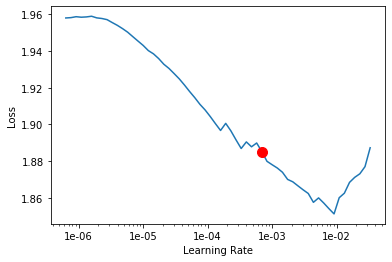

In [45]:
for wd in wds:
    !rm models/bestmodel.pth
    learner.lr_find(wd=wd)#num_it=800, stop_div=False)
    learner.recorder.plot(suggestion=True)
    losses.append(learner.recorder.losses)
    lrs.append(learner.recorder.lrs)

In [46]:
epochs = 300
b_its = len(data.train_dl)
ph1 = (TrainingPhase(epochs*b_its)
            .schedule_hp('wd', (1e-5,1e-1))
            )
gs = GeneralScheduler(learner, (ph1,))
ph1

TrainingPhase(length=46200)

In [47]:
learner.fit_one_cycle(epochs,4.5e-4)#, moms=(0.95,0.85), pct_start=0.3)#,callbacks=gs)

epoch,train_loss,valid_loss,👉🏻LMAE👈🏻,0 1JHC,1 2JHH,2 1JHN,3 2JHN,4 2JHC,5 3JHH,6 3JHC,7 3JHN,time
0,1.555168,1.487136,1.481362,4.444233,0.767140,3.434389,0.606224,0.817156,1.051565,0.876346,-0.146157,01:25
1,1.470963,1.441128,1.432214,4.349187,0.717676,3.344919,0.525993,0.774914,1.039820,0.868909,-0.163707,01:25
2,1.441630,1.417579,1.401510,4.320754,0.670359,3.290622,0.498228,0.733516,1.032315,0.858568,-0.192286,01:26
3,1.417229,1.391529,1.378169,4.298905,0.605773,3.236528,0.501728,0.698389,1.031272,0.853361,-0.200604,01:26
4,1.393421,1.368461,1.349846,4.276328,0.563252,3.173321,0.472606,0.653031,1.023485,0.846981,-0.210238,01:27
5,1.372939,1.346935,1.329939,4.254275,0.548230,3.106954,0.442936,0.637763,1.023586,0.845047,-0.219282,01:26
6,1.356171,1.324034,1.305900,4.229579,0.529578,3.028143,0.417969,0.615952,1.011973,0.837412,-0.223405,01:26
7,1.334724,1.302528,1.282004,4.202112,0.511851,2.934831,0.400204,0.602969,1.002146,0.826995,-0.225076,01:27
8,1.311511,1.276756,1.257837,4.171085,0.504926,2.821570,0.396691,0.592747,0.994703,0.821526,-0.240551,01:27
9,1.288339,1.248891,1.235916,4.136358,0.484979,2.690090,0.369458,0.602313,0.982508,0.821142,-0.199517,01:27


Better model found at epoch 0 with 👉🏻LMAE👈🏻 value: 1.4813621044158936.
Better model found at epoch 1 with 👉🏻LMAE👈🏻 value: 1.4322137832641602.
Better model found at epoch 2 with 👉🏻LMAE👈🏻 value: 1.4015097618103027.
Better model found at epoch 3 with 👉🏻LMAE👈🏻 value: 1.3781691789627075.
Better model found at epoch 4 with 👉🏻LMAE👈🏻 value: 1.3498458862304688.
Better model found at epoch 5 with 👉🏻LMAE👈🏻 value: 1.3299386501312256.
Better model found at epoch 6 with 👉🏻LMAE👈🏻 value: 1.3059000968933105.
Better model found at epoch 7 with 👉🏻LMAE👈🏻 value: 1.2820038795471191.
Better model found at epoch 8 with 👉🏻LMAE👈🏻 value: 1.2578370571136475.
Better model found at epoch 9 with 👉🏻LMAE👈🏻 value: 1.2359163761138916.
Better model found at epoch 10 with 👉🏻LMAE👈🏻 value: 1.21049964427948.
Better model found at epoch 11 with 👉🏻LMAE👈🏻 value: 1.1783148050308228.
Better model found at epoch 12 with 👉🏻LMAE👈🏻 value: 1.148360252380371.
Better model found at epoch 13 with 👉🏻LMAE👈🏻 value: 1.124298095703125.
Better

Better model found at epoch 208 with 👉🏻LMAE👈🏻 value: -1.98381769657135.
Better model found at epoch 209 with 👉🏻LMAE👈🏻 value: -1.9863777160644531.
Better model found at epoch 213 with 👉🏻LMAE👈🏻 value: -1.9933580160140991.
Better model found at epoch 214 with 👉🏻LMAE👈🏻 value: -1.9957845211029053.
Better model found at epoch 215 with 👉🏻LMAE👈🏻 value: -2.0023155212402344.
Better model found at epoch 216 with 👉🏻LMAE👈🏻 value: -2.005697727203369.
Better model found at epoch 217 with 👉🏻LMAE👈🏻 value: -2.0067214965820312.
Better model found at epoch 218 with 👉🏻LMAE👈🏻 value: -2.0117409229278564.
Better model found at epoch 220 with 👉🏻LMAE👈🏻 value: -2.023956775665283.
Better model found at epoch 221 with 👉🏻LMAE👈🏻 value: -2.028182029724121.
Better model found at epoch 227 with 👉🏻LMAE👈🏻 value: -2.030336856842041.
Better model found at epoch 230 with 👉🏻LMAE👈🏻 value: -2.0373029708862305.
Better model found at epoch 231 with 👉🏻LMAE👈🏻 value: -2.049069404602051.
Better model found at epoch 234 with 👉🏻LMAE👈🏻

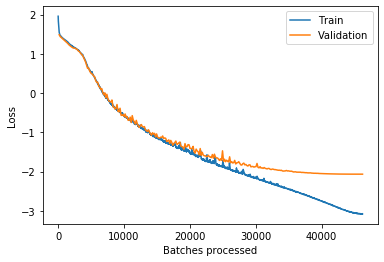

In [48]:
learner.recorder.plot_losses()

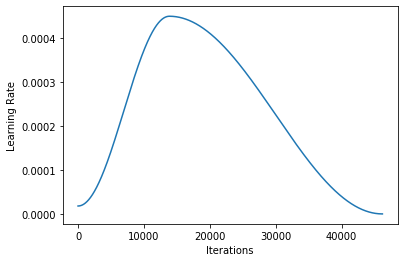

In [49]:
learner.recorder.plot_lr()

/home/antor/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128073 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/antor/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/antor/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128072 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/antor/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 128073 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/antor/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/antor/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.p

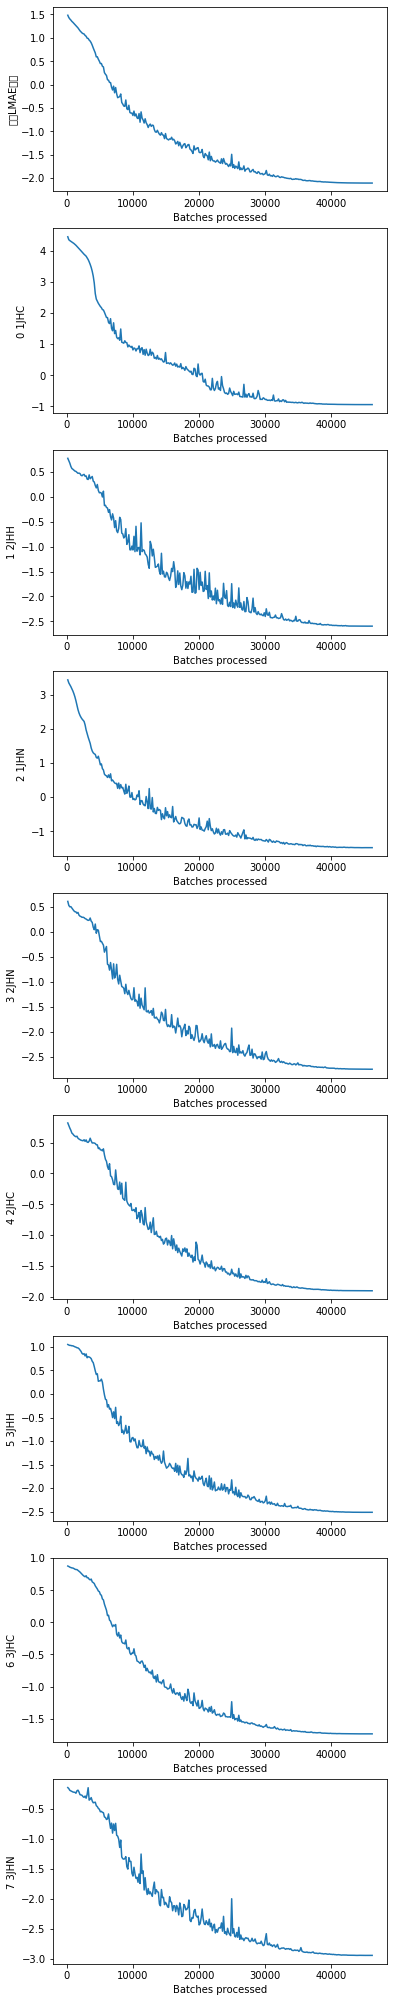

In [50]:
learner.recorder.plot_metrics()

# Lookahead

In [ ]:
from collections import defaultdict
from itertools import chain
import warnings

class Lookahead(torch.optim.Optimizer):
    def __init__(self, optimizer, k=5, alpha=0.5):
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        for group in self.param_groups:
            group["counter"] = 0
    
    def update(self, group):
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)
    
    def update_lookahead(self):
        for group in self.param_groups:
            self.update(group)

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss

    def state_dict(self):
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }

    def load_state_dict(self, state_dict):
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state

    def add_param_group(self, param_group):
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)

## Optional Fine tune regular fit 

In [ ]:
learner.callbacks.append(
    ReduceLROnPlateauCallback(learner, monitor='train_loss', mode='min', factor=0.2, patience=2))

In [ ]:
try:
    base_opt
except:
    base_opt = learner.opt.opt

In [ ]:
base_opt

In [ ]:
lookahead = Lookahead(base_opt, k=5, alpha=0.5) # Initialize Lookahead

In [ ]:
learner.opt = OptimWrapper(lookahead)
learner.opt_func = lookahead

In [ ]:
learner.opt

In [ ]:
learner.fit(10, 4e-4)

In [ ]:
learner.fit(50, 3e-4)

In [ ]:
learner.fit(50, 1e-4)

In [ ]:
learner.fit(50, 8e-5)

In [ ]:
learner.fit(10, 6e-5)

In [ ]:
learner.fit(10, 5e-5)

In [ ]:
learner.fit(10, 3e-5)

In [ ]:
learner.fit(10, 8e-6)

In [ ]:
learner.recorder.plot_lr(show_moms=True)

In [ ]:
learner.recorder.plot_losses()

In [ ]:
learner.recorder.plot_metrics()

In [ ]:
learner.fit(10,1e-4)

# Validate

In [51]:
learner.to_fp32()
val = learner.validate()[1]
print(val)

Better model found at epoch 0 with 👉🏻LMAE👈🏻 value: -2.1061410903930664.
tensor(-2.1067, device='cuda:0')


In [52]:
try:
    sub_fname = f'loss{learner.recorder.losses[-1]:.04f}val{val:.04f}'
except:
    sub_fname = f'val{val:.04f}'
learner.save(sub_fname)
print(sub_fname)

loss-3.0757val-2.1067


# Inference

Make sure `tranforms` are activated to test set otherwise TTA > 1 will be as TTA =1

In [ ]:
test_fname = Path('test.npz')
try:
    npzfile  = np.load(fname_ext(test_fname, ext))
    xt_xyz   = npzfile['x_xyz']
    xt_type  = npzfile['x_type']
    xt_ext   = npzfile['x_ext']
    xt_atom  = npzfile['x_atom']
    mt = npzfile['m']
    xt_ids = npzfile['x_ids']
except:
    xt_xyz,xt_type,xt_ext,xt_atom,mt,xt_ids = \
        preprocess(test_fname.with_suffix('.csv'), type_index=types,ext=ext)
    np.savez(fname_ext('_'+test_fname, ext), 
             x_xyz  = xt_xyz,
             x_type = xt_type,
             x_ext  = xt_ext,
             x_atom = xt_atom,
             m=mt,
             x_ids=xt_ids)

In [ ]:
xt_qm9_mulliken = load_fn(f'xt_qm9_mulliken{ext}.npy')

In [ ]:
[v.shape for v in [xt_xyz,xt_type,xt_ext,xt_atom, xt_qm9_mulliken,xt_ids, mt]]

In [ ]:
learner.data.add_test(ItemList(items=(MoleculeItem(i,*v) for i,v in 
                              enumerate(zip(xt_xyz,xt_type,xt_ext,xt_atom,xt_qm9_mulliken)))))

In [ ]:
TTA_N = 1
learner.data.test_ds.tfms = tta_tfms if TTA_N > 1 else tfms

In [ ]:
#learner.model = learner.model.module
#data.batch_size = 4096*2

In [ ]:
#learner.model = nn.DataParallel(learner.model)
old_bs = data.batch_size
data.batch_size *= 2

sub = defaultdict(int)
xt_ids_not_extended = (xt_ids!=0) & (xt_ids<=7163688) # TODO
ids = xt_ids[xt_ids_not_extended]

mb = master_bar(range(TTA_N))
for tta in mb:
    test_preds = np.zeros((0, 29), dtype=np.float32)

    for batch_idx, batch in progress_bar(
        enumerate(learner.dl(DatasetType.Test)), total=len(learner.dl(DatasetType.Test)), parent=mb):
        _, _, preds_,_,_,_ = learner.pred_batch(ds_type=DatasetType.Test, batch=batch)
        preds_ = preds_.sum(dim=1)
        test_preds = np.concatenate([test_preds, preds_.data.cpu().numpy()], axis = 0)

    preds = test_preds[xt_ids_not_extended]
    for k in range(len(ids)):
        sub[int(ids[k])] += preds[k]
    
for k in range(len(ids)):
    sub[int(ids[k])] = sub[int(ids[k])]/TTA_N

learner.model = learner.model.module
data.batch_size = old_bs

sub_df = pd.DataFrame(sub.items(), columns=['id', 'scalar_coupling_constant'])
sub_df.head()

# Submit to Kaggle

In [ ]:
csv_fname = f'{sub_fname}_tta{TTA_N}.csv'
sub_df.to_csv(csv_fname, index=False)

In [ ]:
comp = 'champs-scalar-coupling'

In [ ]:
!kaggle competitions submit -c {comp} -f {csv_fname} -m 'QM9 tta {TTA_N} {ext}'

In [ ]:
import time
time.sleep(60)
!kaggle competitions submissions -c {comp} -v > submissions-{comp}.csv

In [ ]:
submissions = pd.read_csv(f'submissions-{comp}.csv')
submissions.iloc[0].publicScore